In [10]:
import os
from dotenv import load_dotenv
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime

In [11]:
# Загружаем переменные из .env файла
dotenv_path = r"C:\Users\palux\OneDrive\Документы\Python files DS\VK_api\token.env"

load_dotenv(dotenv_path)

# Получаем значения переменных
ACCESS_TOKEN = os.getenv('ACCESS_TOKEN')
GROUP_ID = os.getenv('GROUP_ID')
API_VERSION = os.getenv('API_VERSION')


In [12]:
url = 'https://api.vk.com/method/groups.getMembers'

# Узнаем общее количество подписчиков
params_count = {
    'group_id': GROUP_ID,
    'access_token': ACCESS_TOKEN,
    'v': API_VERSION
}
response = requests.get(url, params=params_count).json()

if 'response' in response:
    total_count = response['response']['count']
    print(f"Всего подписчиков: {total_count}")
else:
    print("Ошибка при получении количества подписчиков:", response)
    total_count = 0

Всего подписчиков: 96243


In [14]:
# Узнаем общее количество подписчиков
params_count = {
    'group_id': GROUP_ID,
    'access_token': ACCESS_TOKEN,
    'v': API_VERSION
}
response = requests.get(url, params=params_count).json()
total_count = response['response']['count']
print(f"Всего подписчиков: {total_count}")

# Цикл по всем offset (по 1000 за раз)
all_users = []

for offset in range(0, 10000, 1000):
    params = {
        'group_id': GROUP_ID,
        'fields': 'sex,bdate,city,universities,relation,personal,followers_count,last_seen,status,has_photo',
        'access_token': ACCESS_TOKEN,
        'v': API_VERSION,
        'count': 1000,
        'offset': offset
    }

    response = requests.get(url, params=params).json()

    if 'response' in response:
        users = response['response']['items']
        all_users.extend(users)
        print(f"Собрано: {len(all_users)} пользователей")
    else:
        print(f"Ошибка на offset {offset}: {response}")
        break

    time.sleep(0.01)  # Пауза между запросами

# В DataFrame
df = pd.DataFrame(all_users)

Всего подписчиков: 96243
Собрано: 1000 пользователей
Собрано: 2000 пользователей
Собрано: 3000 пользователей
Собрано: 4000 пользователей
Собрано: 5000 пользователей
Собрано: 6000 пользователей
Собрано: 7000 пользователей
Собрано: 8000 пользователей
Собрано: 9000 пользователей
Собрано: 10000 пользователей


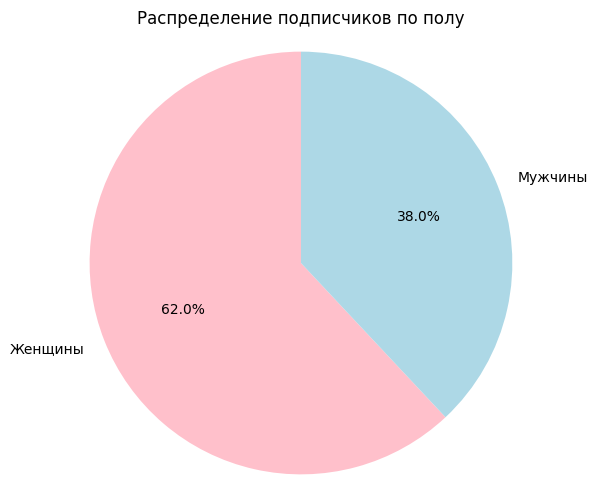

In [15]:
# Фильтруем только пол 1 и 2
df_sex = df[df['sex'].isin([1, 2])]

# Считаем
sex_counts = df_sex['sex'].value_counts().sort_index()

# Подписи
labels = ['Женщины', 'Мужчины']

# Круговая диаграмма
plt.figure(figsize=(6, 6))
plt.pie(sex_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['pink', 'lightblue'])
plt.title('Распределение подписчиков по полу')
plt.axis('equal')
plt.show()


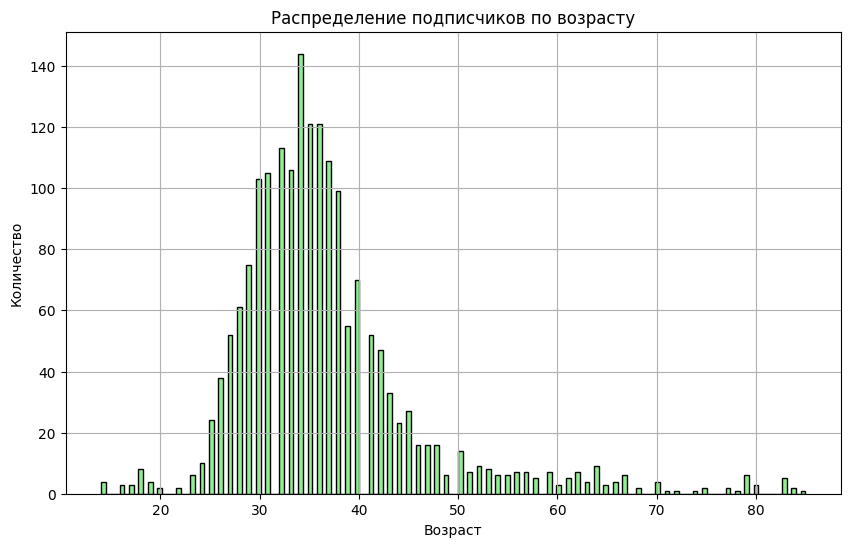

In [16]:
# Фильтруем только пользователей с полной датой рождения
df_bdate = df[df['bdate'].notnull()]
df_bdate = df_bdate[df_bdate['bdate'].str.count(r'\.') == 2]  # полные даты

# Вычислим возраст
def calculate_age(bdate_str):
    day, month, year = map(int, bdate_str.split('.'))
    today = datetime.datetime.today()
    age = today.year - year - ((today.month, today.day) < (month, day))
    return age

df_bdate['age'] = df_bdate['bdate'].apply(calculate_age)

# Оставим возраст 10-80 лет
df_age = df_bdate[(df_bdate['age'] >= 10) & (df_bdate['age'] <= 90)]

# Столбцовая диаграмма
plt.figure(figsize=(10, 6))
df_age['age'].plot(kind='hist', bins=150, color='lightgreen', edgecolor='black')
plt.title('Распределение подписчиков по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True)
plt.show()


In [17]:
# Извлекаем только название города
df['city_title'] = df['city'].apply(lambda x: x['title'] if pd.notna(x) and isinstance(x, dict) else None)

In [18]:
# Безопасное извлечение: сначала проверка на NaN, затем на list, потом на ключи
df['university_name'] = df['universities'].apply(
    lambda x: (
        x[0].get('name') or x[0].get('chair_name')
    ) if isinstance(x, list) and len(x) > 0 else None
)


Топ вузов:
university
ТувГУ                            89
ТывГУ                            87
СФУ                              19
СИУ РАНХиГС (СибАГС)             15
БГСХА                            13
АГМУ\r\n                         12
МГУ                              12
ХГУ (бывш. АГПИ) им. Катанова    11
ВСГИК (бывш. ВСГАКИ)             11
БГУ (бывш. БГПИ, БФ НГУ)         11
Name: count, dtype: int64


) missing from font(s) DejaVu Sans.pykernel_20688\300560256.py:30: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.on\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


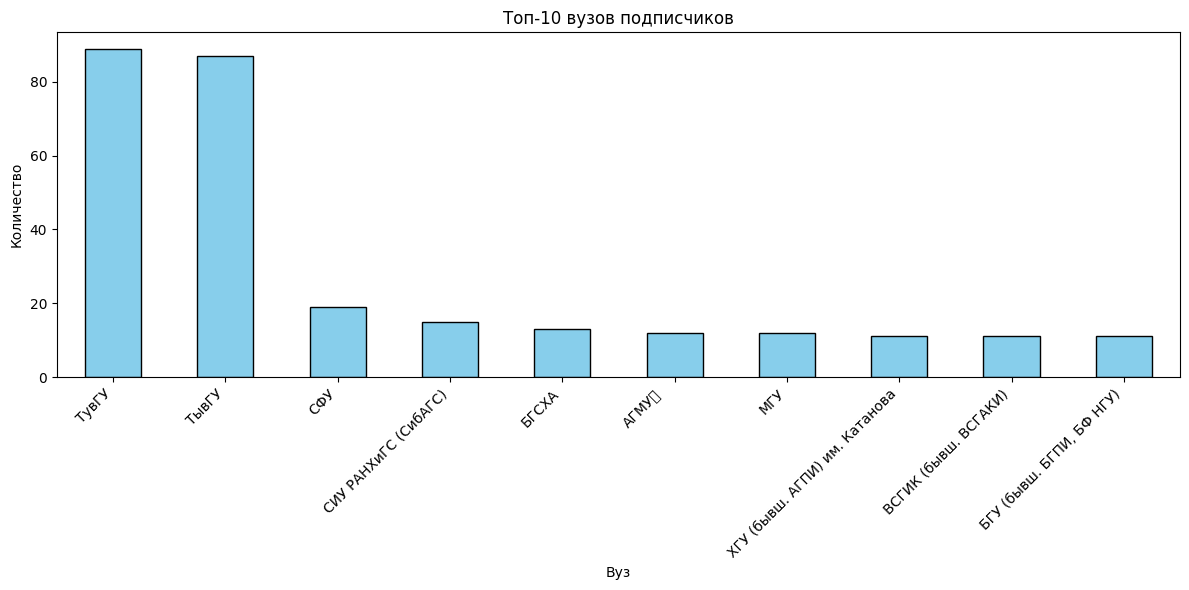

In [19]:
# Собираем все названия вузов из корректных списков
universities_list = []

for user in df['universities'].dropna():
    try:
        if isinstance(user, list):  # Проверяем, что это список
            for uni in user:
                name = uni.get('name') or uni.get('chair_name')  # Берём 'name' или 'chair_name'
                if name:
                    universities_list.append(name)
    except Exception as e:
        continue  # Пропускаем ошибки

# В DataFrame и считаем
df_uni = pd.DataFrame(universities_list, columns=['university'])
top_unis = df_uni['university'].value_counts().head(10)

# Проверим, есть ли что-то для построения
print("Топ вузов:")
print(top_unis)

# Строим график только если есть данные
if not top_unis.empty:
    plt.figure(figsize=(12, 6))
    top_unis.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Топ-10 вузов подписчиков')
    plt.xlabel('Вуз')
    plt.ylabel('Количество')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных о вузах для визуализации.")


In [20]:
df.groupby('deactivated')['first_name'].count()

deactivated
banned      501
deleted    1437
Name: first_name, dtype: int64

In [21]:
df['sex'].value_counts()

sex
1    6196
2    3800
0       4
Name: count, dtype: int64

In [22]:
df.sort_values(ascending=False, by=['followers_count'])

,id,city,has_photo,last_seen,followers_count,relation,personal,universities,sex,first_name,last_name,can_access_closed,is_closed,status,bdate,deactivated,relation_partner,status_audio,city_title,university_name
491,9595595,"{'id': 73, 'title': 'Krasnoyarsk'}",1,"{'platform': 7, 'time': 1743595484}",28061.0,6.0,"{'alcohol': 0, 'inspired_by': 'Грег Плит, Арно...",[],2,Ivan,Vladimirovich,True,False,,22.12.1988,NaN,NaN,NaN,Krasnoyarsk,None
8699,141126295,"{'id': 1, 'title': 'Moscow'}",1,"{'platform': 4, 'time': 1743586218}",23531.0,1.0,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...",[],2,Oleg,Demyokhin,True,False,№ 4915146633 номер заявления в Роскомнадзор на...,25.12,NaN,NaN,NaN,Moscow,None
2297,54945083,NaN,1,"{'platform': 2, 'time': 1743603164}",20623.0,4.0,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'chair': 64263, 'chair_name': 'Агрономия', '...",2,Sergey,Zhestyannikov,True,False,Для Роскомнадзора № 5051061299 Председатель За...,NaN,NaN,NaN,NaN,None,ВГМХА им. Верещагина
8048,138177444,"{'id': 76, 'title': 'Kyzyl'}",1,"{'platform': 2, 'time': 1743603092}",20280.0,NaN,NaN,NaN,2,Pozyvnoy,Artist,True,False,🙏🏻ҮШ ХОВАР ДЭЭДИ ЭРТИНЕДЕН АВЫРАЛ КАМГАЛАЛДЫ Д...,30.1,NaN,NaN,NaN,Kyzyl,None
1362,29535764,NaN,1,"{'platform': 7, 'time': 1743600306}",16646.0,NaN,NaN,NaN,1,Diana,Dovut,True,False,Акуна матата,NaN,NaN,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,149152317,NaN,1,"{'platform': 4, 'time': 1743601389}",NaN,NaN,NaN,NaN,2,Eres,Ool,False,True,,NaN,NaN,NaN,NaN,None,None
9982,149155912,"{'id': 76, 'title': 'Kyzyl'}",0,NaN,NaN,NaN,NaN,NaN,1,DELETED,,True,False,NaN,29.7,deleted,NaN,NaN,Kyzyl,None
9987,149167716,"{'id': 76, 'title': 'Kyzyl'}",1,"{'platform': 4, 'time': 1743602411}",NaN,NaN,NaN,NaN,1,Yulia,Mongush,False,True,...,10.4,NaN,NaN,NaN,Kyzyl,None
9991,149212894,"{'id': 76, 'title': 'Kyzyl'}",1,"{'platform': 4, 'time': 1743602231}",NaN,NaN,NaN,NaN,1,Ruslana,Irgit,False,True,,4.11,NaN,NaN,NaN,Kyzyl,None


In [23]:
df.groupby('first_name')['relation'].count().sort_values(ascending=False)

first_name
Alexander        28
Alexey           21
Aydyn            20
Choduraa         17
Arzhaana         16
                 ..
Adygjy            0
Zhanneta          0
Zhasmin           0
Zhemchuzhnaya     0
Zhenka            0
Name: relation, Length: 1861, dtype: int64